In [38]:
from luxai_s2.env import LuxAI_S2
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import distance_transform_cdt
from tqdm import tqdm

ore_mult_1 = 0.8
second_fact_mult = 1/2

In [39]:
def manhattan_distance(binary_mask):
    # Get the distance map from every pixel to the nearest positive pixel
    distance_map = distance_transform_cdt(binary_mask, metric='taxicab')
    return distance_map

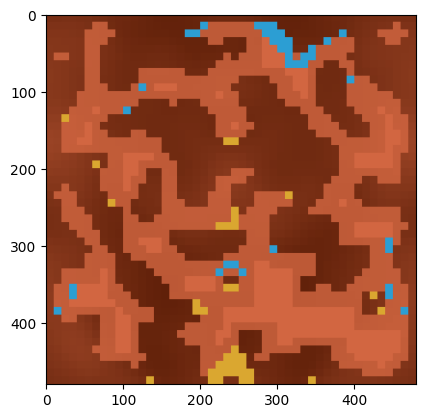

In [40]:
env = LuxAI_S2()
obs = env.reset(seed=1)
#obs = env.reset()
img = env.render("rgb_array", width=480, height=480)
plt.imshow(img)

In [41]:
ice = obs['player_0']["board"]["ice"]
ore = obs['player_0']["board"]["ore"]
dist_ice = manhattan_distance(1 - ice)
dist_ore = manhattan_distance(1 - ore)
scores = dist_ice + dist_ore * 0.9 # *0.9 just to make it tie breaker, 2 from ice and 3 from ore beats 3 from ice and 2 from ore

valid_spawns = obs["player_0"]["board"]["valid_spawns_mask"] #not masking out any zeros because there are none; can't be distance zero to both ice and ore
valid_spawns = np.ones(valid_spawns.shape) * valid_spawns + 0.0001
scores = scores / valid_spawns
sorted_indexes = np.argsort(scores, axis=None)

less = 100
topN =  [np.unravel_index(index, (48, 48)) for index in sorted_indexes[:less]]
dist_ice_2, dist_ore_2 = [], []
for x,y in topN:
    closest_ice = min(
        dist_ice[x-1,y-1],
        dist_ice[x-1,y],
        dist_ice[x-1,y+1],
        dist_ice[x,y-1],
        #dist_ice[x,y],
        dist_ice[x,y+1],
        dist_ice[x+1,y-1],
        dist_ice[x+1,y],
        dist_ice[x+1,y+1]
    )
    dist_ice_2.append(closest_ice)
    closest_ore = min(
        dist_ore[x-1,y-1],
        dist_ore[x-1,y],
        dist_ore[x-1,y+1],
        dist_ore[x,y-1],
        #dist_ore[x,y],
        dist_ore[x,y+1],
        dist_ore[x+1,y-1],
        dist_ore[x+1,y],
        dist_ore[x+1,y+1]
    )
    dist_ore_2.append(closest_ore)
    
scores = dist_ice_2 + np.array(dist_ore_2) * ore_mult_1
sorted_indexes = np.argsort(scores)
#display(sorted_indexes)

no_overlap = [] #list of locations sorted by score and non overlapping
corresponding_scores = [] #list of corresponding scores
for i in sorted_indexes:
    loc = np.array(topN[i])
    score = scores[i]
    if len(no_overlap) == 0:
        no_overlap.append(loc)
        corresponding_scores.append(score)
        continue
    if any([np.sum(np.abs(loc-placed)) < 6 for placed in no_overlap]):
        continue
    no_overlap.append(loc)
    corresponding_scores.append(score)
_scores = corresponding_scores.copy()
first_vs_second = (_scores[0] - _scores[1]) + second_fact_mult * (_scores[2] - _scores[3])
first_vs_second

0.0

In [ ]:
#metric for placing factory: 'intended territory'

#pseudocode: proceeding through argsorted ice-ore distances, a factory location has N intended territory defined as size
    # of contested tiles w rubble <= 35

#rubble=0 tile at distance n from factory center loc has value (46+46)/(n-1) --- (since n >= 2 for non factory tiles)
#disregard all eight factory tiles (i+-1/0, j+-1/0),
#


#if tile is clos

In [ ]:
# judge new positions by change in total board state if we were to build there

In [ ]:
from tqdm import tqdm

In [ ]:
for _ in range(len(valid_spawns)):
    print(_)
    print(valid_spawns[_])

In [ ]:
rubble = obs['player_0']['board']['rubble']
rubble.shape
conv_size = 8
y = rubble.reshape(conv_size,conv_size, int(rubble.shape[0]/conv_size), int(rubble.shape[1]/conv_size))
y

In [ ]:
rubble_all = []
rubble_means = []
mountain_count, cave_count = 0,0
for n in np.arange(300,800):
    obs = env.reset(seed=n)
    m = np.mean(obs['player_0']['board']['rubble'])
    if m < 35:
        mountain_count += 1
    else:
        cave_count += 1
    rubble_means.append(m)
plt.hist(rubble_means, bins=50)
plt.show()
mountain_count, cave_count

In [ ]:
def animate(imgs, _return=True):
    # using cv2 to generate videos as moviepy doesn't work on kaggle notebooks
    import cv2
    import os
    import string
    import random
    video_name = ''.join(random.choice(string.ascii_letters) for i in range(18))+'.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width,height))

    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
    if _return:
        from IPython.display import Video
        return Video(video_name)
def interact(env, agents, steps):
    # reset our env
    obs = env.reset(seed=41)
    np.random.seed(0)
    imgs = []
    step = 0
    # Note that as the environment has two phases, we also keep track a value called 
    # `real_env_steps` in the environment state. The first phase ends once `real_env_steps` is 0 and used below

    # iterate until phase 1 ends
    while env.state.real_env_steps < 0:
        if step >= steps: break
        actions = {}
        for player in env.agents:
            o = obs[player]
            a = agents[player].early_setup(step, o)
            actions[player] = a
        step += 1
        obs, rewards, dones, infos = env.step(actions)
        imgs += [env.render("rgb_array", width=400, height=400)]
    done = False
    while not done:
        if step >= steps: break
        actions = {}
        for player in env.agents:
            o = obs[player]
            a = agents[player].act(step, o)
            actions[player] = a
        step += 1
        obs, rewards, dones, infos = env.step(actions)
        imgs += [env.render("rgb_array", width=400, height=400)]
        done = dones["player_0"] and dones["player_1"]
    return animate(imgs)

In [ ]:
# recreate our agents and run
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, 25)

Some factories are surviving for for more than 100 steps thanks to the delivery of additional ice, but more work will need to be done to keep them alive longer.

Puting all those pieces together the full starter agent looks like this (and we will save it to agent.py)

In [ ]:
#%%writefile test_agent6.py
from lux.kit import obs_to_game_state, GameState, EnvConfig
from lux.utils import direction_to, my_turn_to_place_factory
import numpy as np
import sys
class TestAgent_0():
    def __init__(self, player: str, env_cfg: EnvConfig) -> None:
        self.player = player
        self.opp_player = "player_1" if self.player == "player_0" else "player_0"
        np.random.seed(0)
        self.env_cfg: EnvConfig = env_cfg

    def early_setup(self, step: int, obs, remainingOverageTime: int = 60):
        #print('asdfasdf')
        if step == 0:
            # bid 0 to not waste resources bidding and declare as the default faction
            return dict(faction="AlphaStrike", bid=0)
        else:
            game_state = obs_to_game_state(step, self.env_cfg, obs)
            # factory placement period

            # how much water and metal you have in your starting pool to give to new factories
            water_left = game_state.teams[self.player].water
            metal_left = game_state.teams[self.player].metal

            # how many factories you have left to place
            factories_to_place = game_state.teams[self.player].factories_to_place
            # whether it is your turn to place a factory
            my_turn_to_place = my_turn_to_place_factory(game_state.teams[self.player].place_first, step)
            if factories_to_place > 0 and my_turn_to_place:
                # we will spawn our factory in a random location with 150 metal and water if it is our turn to place
                potential_spawns = np.array(list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1))))
                spawn_loc = potential_spawns[np.random.randint(0, len(potential_spawns))]
                return dict(spawn=spawn_loc, metal=150, water=150)
            return dict()

    def act(self, step: int, obs, remainingOverageTime: int = 60):
        #print('asdf')
        actions = dict()
        game_state = obs_to_game_state(step, self.env_cfg, obs)
        factories = game_state.factories[self.player]
        
        #print('pla')
        #display(game_state.factories[self.player])
        #print('opp')
        #display(game_state.factories[self.opp_player])
        
        game_state.teams[self.player].place_first
        factory_tiles, factory_units = [], []
        for unit_id, factory in factories.items():
            if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
            factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
                actions[unit_id] = factory.build_heavy()
            if self.env_cfg.max_episode_length - game_state.real_env_steps < 50:
                if factory.water_cost(game_state) <= factory.cargo.water:
                    actions[unit_id] = factory.water()
            factory_tiles += [factory.pos]
            factory_units += [factory]
        factory_tiles = np.array(factory_tiles)

        units = game_state.units[self.player]
        ice_map = game_state.board.ice
        ice_tile_locations = np.argwhere(ice_map == 1)
        for unit_id, unit in units.items():

            # track the closest factory
            closest_factory = None
            adjacent_to_factory = False
            if len(factory_tiles) > 0:
                factory_distances = np.mean((factory_tiles - unit.pos) ** 2, 1)
                closest_factory_tile = factory_tiles[np.argmin(factory_distances)]
                closest_factory = factory_units[np.argmin(factory_distances)]
                adjacent_to_factory = np.mean((closest_factory_tile - unit.pos) ** 2) == 0

                # previous ice mining code
                if unit.cargo.ice < 40:
                    ice_tile_distances = np.mean((ice_tile_locations - unit.pos) ** 2, 1)
                    closest_ice_tile = ice_tile_locations[np.argmin(ice_tile_distances)]
                    if np.all(closest_ice_tile == unit.pos):
                        if unit.power >= unit.dig_cost(game_state) + unit.action_queue_cost(game_state):
                            actions[unit_id] = [unit.dig(repeat=0)]
                    else:
                        direction = direction_to(unit.pos, closest_ice_tile)
                        move_cost = unit.move_cost(game_state, direction)
                        if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
                            actions[unit_id] = [unit.move(direction, repeat=0)]
                # else if we have enough ice, we go back to the factory and dump it.
                elif unit.cargo.ice >= 40:
                    direction = direction_to(unit.pos, closest_factory_tile)
                    if adjacent_to_factory:
                        if unit.power >= unit.action_queue_cost(game_state):
                            actions[unit_id] = [unit.transfer(direction, 0, unit.cargo.ice, repeat=0)]
                    else:
                        move_cost = unit.move_cost(game_state, direction)
                        if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
                            actions[unit_id] = [unit.move(direction, repeat=0)]
        return actions

In [ ]:
env.agents

In [ ]:
#ctrlf

#from test_agent6 import TestAgent


agents = {
    env.agents[0]: TestAgent_0(env.agents[0], env.state.env_cfg),
    env.agents[1]: TestAgent_1(env.agents[1], env.state.env_cfg),
}
interact(env, agents, 10)

## Create a submission
Now we need to create a .tar.gz file with main.py (and agent.py) at the top level. We can then upload this!

In [ ]:
!tar -czf submission.tar.gz *

## Submit
Now open the /kaggle/working folder and find submission.tar.gz, download that file, navigate to the "MySubmissions" tab in https://www.kaggle.com/c/lux-ai-season-2/ and upload your submission! It should play a validation match against itself and once it succeeds it will be automatically matched against other players' submissions. Newer submissions will be prioritized for games over older ones. Your team is limited in the number of succesful submissions per day so we highly recommend testing your bot locally before submitting.

## CLI Tool

To test your agent without using the python API you can also run

In [ ]:
!luxai-s2 main.py main.py -v 2 -s 101 -o replay.json

which uses a random seed and generates a replay.html file that you can click and watch. Optionally if you specify `-o replay.json` you can upload replay.json to http://s2vis.lux-ai.org/.

The CLI tool enables you to easily run episodes between any two agents (python or not) and provides a flexible tournament running tool to evaluate many agents together. Documentation on this tool can be found here: https://github.com/Lux-AI-Challenge/Lux-Design-S2/tree/main/luxai_runner/README.md

In [ ]:
import IPython
IPython.display.HTML(filename='replay.html')

And they're off! The heavy robots have started to move towards the ice tiles and some have begun mining.

#### Delivering Resources and Keep Factories Alive
We now have ice being mined, but we now need to deliver that back to the factories so they can refine that ice into water and sustain themselves.

In [ ]:
def act(self, step: int, obs, remainingOverageTime: int = 60):
    actions = dict()
    game_state = obs_to_game_state(step, self.env_cfg, obs)
    factories = game_state.factories[self.player]
    factory_tiles, factory_units = [], []
    for unit_id, factory in factories.items():
        if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
        factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
            actions[unit_id] = factory.build_heavy()
        factory_tiles += [factory.pos]
        factory_units += [factory]
    factory_tiles = np.array(factory_tiles)

    units = game_state.units[self.player]
    ice_map = game_state.board.ice
    ice_tile_locations = np.argwhere(ice_map == 1)
    for unit_id, unit in units.items():
        
        # track the closest factory
        closest_factory = None
        adjacent_to_factory = False
        if len(factory_tiles) > 0:
            factory_distances = np.mean((factory_tiles - unit.pos) ** 2, 1)
            closest_factory_tile = factory_tiles[np.argmin(factory_distances)]
            closest_factory = factory_units[np.argmin(factory_distances)]
            adjacent_to_factory = np.mean((closest_factory_tile - unit.pos) ** 2) == 0
        
            # previous ice mining code
            if unit.cargo.ice < 40:
                ice_tile_distances = np.mean((ice_tile_locations - unit.pos) ** 2, 1)
                closest_ice_tile = ice_tile_locations[np.argmin(ice_tile_distances)]
                if np.all(closest_ice_tile == unit.pos):
                    if unit.power >= unit.dig_cost(game_state) + unit.action_queue_cost(game_state):
                        actions[unit_id] = [unit.dig(repeat=0)]
                else:
                    direction = direction_to(unit.pos, closest_ice_tile)
                    move_cost = unit.move_cost(game_state, direction)
                    if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
                        actions[unit_id] = [unit.move(direction, repeat=0)]
            # else if we have enough ice, we go back to the factory and dump it.
            elif unit.cargo.ice >= 40:
                direction = direction_to(unit.pos, closest_factory_tile)
                if adjacent_to_factory:
                    if unit.power >= unit.action_queue_cost(game_state):
                        actions[unit_id] = [unit.transfer(direction, 0, unit.cargo.ice, repeat=0)]
                else:
                    move_cost = unit.move_cost(game_state, direction)
                    if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
                        actions[unit_id] = [unit.move(direction, repeat=0)]
    return actions
Agent.act = act

In [ ]:
# recreate our agents and run
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, 300)

In [ ]:
img = env.render("rgb_array", width=640, height=640)
plt.imshow(img)